In [1]:
"""
Video & Audio Confidence Classification Pipeline with Attention Pooling
======================================================================

This code:
1. Installs required packages (if missing).
2. Finds the dataset under /kaggle/input (expects videos/videos and a CSV).
3. Splits each video into 10 s clips (discarding segments < 3 s, no padding).
4. Extracts VideoMAE and WavLM embeddings for each clip, concatenates them → h_i.
5. Trains an attention-based pooling + MLP classifier via 5-fold stratified CV.
6. Prints metrics per fold and confusion matrices (raw and normalized).
7. Trains the same attention/MLP on all data, saves model/state/config/classmap.
8. Bundles the final model into a zip for easy download.
"""

import os
import sys
import subprocess
import importlib
import warnings
import glob
import random
from typing import List, Tuple

warnings.filterwarnings("ignore")


In [2]:

# ------------------------------------------------------------------------------
# 1) Install dependencies (Kaggle environment typically has most of these)
# ------------------------------------------------------------------------------

os.environ.setdefault("XDG_RUNTIME_DIR", "/tmp/runtime-root")
os.makedirs(os.environ["XDG_RUNTIME_DIR"], exist_ok=True)
os.environ.setdefault("SDL_AUDIODRIVER", "dummy")

def ensure(pkg: str, import_name: str = None, min_version: str = None) -> None:
    name = import_name or pkg
    try:
        mod = importlib.import_module(name)
        if min_version:
            from importlib.metadata import version, PackageNotFoundError
            from packaging.version import Version
            try:
                ver = version(name)
                if Version(ver) < Version(min_version):
                    raise Exception(f"{name} < {min_version}")
            except PackageNotFoundError:
                raise
        return
    except Exception:
        spec = pkg if not min_version else f"{pkg}>={min_version}"
        print(f"[install] {spec}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", spec])

# Essential packages
ensure("numpy")
ensure("pandas")
ensure("scikit-learn", "sklearn")
ensure("scipy")
ensure("matplotlib")
ensure("seaborn")
ensure("torch")
ensure("transformers", min_version="4.31.0")
ensure("torchaudio")
ensure("moviepy")
ensure("opencv-python-headless", "cv2")

In [4]:
# ------------------------------------------------------------------------------
# 2) Imports and patch SciPy simps if missing
# ------------------------------------------------------------------------------

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    cohen_kappa_score,
    mean_absolute_error,
    balanced_accuracy_score,
    f1_score,
)
from scipy.stats import spearmanr
import scipy.integrate

if not hasattr(scipy.integrate, "simps"):
    from scipy.integrate import simpson
    def _alias_simps(*args, **kwargs):
        return simpson(*args, **kwargs)
    scipy.integrate.simps = _alias_simps

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import VideoMAEModel, WavLMModel
try:
    from transformers import VideoMAEImageProcessor as VideoMAEFeatureExtractor
except ImportError:
    from transformers import VideoMAEFeatureExtractor
from transformers import AutoFeatureExtractor

from moviepy.editor import VideoFileClip
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

print("[ok] Core imports loaded.")


2025-10-06 03:15:34.614511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759720534.945668      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759720535.040729      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[ok] Core imports loaded.


In [5]:
# ------------------------------------------------------------------------------
# 3) Config, reproducibility, constants
# ------------------------------------------------------------------------------

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

VIDEOMAE_CKPT = "MCG-NJU/videomae-base"
WAVLM_CKPT    = "microsoft/wavlm-base-plus"

CLIP_SECONDS    = 10
FRAMES_PER_CLIP = 16
CLIPS_PER_VIDEO = 5
VIDEO_EXTS      = [".mp4", ".mov", ".mkv", ".avi", ".webm"]
CACHE_DIR       = "/kaggle/working/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# Training hyperparams
STAGE1_EPOCHS = 15
LR_STAGE1     = 1e-3
DROPOUT       = 0.30
WEIGHT_DECAY  = 1e-4
BATCH_SIZE    = 4
ATTN_DIM      = 256  # hidden size for attention scoring network

# Final training hyperparams
FINAL_EPOCHS       = 50
FINAL_PATIENCE     = 3
FINAL_HIDDEN_DIM   = 512

# Baseline metrics for comparison (optional)
BASELINE = {"MAE": 1.000, "QWK": 0.000, "ACC": 0.167, "RHO": np.nan,
           "ECE": 0.317, "BAL": 0.167, "F1": 0.0}

In [6]:
# ------------------------------------------------------------------------------
# 4) Dataset discovery helpers
# ------------------------------------------------------------------------------

def find_dataset_root() -> Tuple[str, str, str]:
    candidates = glob.glob("/kaggle/input/*")
    for base in candidates:
        videos_dir = os.path.join(base, "videos", "videos")
        csvs = glob.glob(os.path.join(base, "*.csv"))
        if os.path.isdir(videos_dir) and csvs:
            return base, videos_dir, csvs[0]
    for base in candidates:
        for csv_path in glob.glob(os.path.join(base, "**", "*.csv"), recursive=True):
            parent = os.path.dirname(csv_path)
            vids = glob.glob(os.path.join(parent, "**", "videos"), recursive=True)
            for v in vids:
                vv = os.path.join(v, "videos")
                if os.path.isdir(vv):
                    return base, vv, csv_path
    raise FileNotFoundError("Dataset with videos/videos folder and a CSV not found.")

def read_labels(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df = df.rename(columns={df.columns[0]: "video_filename", df.columns[1]: "score"})
    df["score"] = df["score"].astype(int)
    return df

def resolve_video_path(videos_dir: str, filename: str) -> str:
    base = os.path.splitext(filename)[0]
    for ext in VIDEO_EXTS:
        candidate = os.path.join(videos_dir, base + ext)
        if os.path.isfile(candidate):
            return candidate
    cand = os.path.join(videos_dir, filename)
    if os.path.isfile(cand):
        return cand
    return None

In [7]:
# ------------------------------------------------------------------------------
# 5) Clip selection, augmentation, frame/audio loading
# ------------------------------------------------------------------------------

def split_into_segments(duration: float) -> List[Tuple[float, float]]:
    n_full = int(duration // CLIP_SECONDS)
    starts = [i * CLIP_SECONDS for i in range(n_full)]
    rem = duration - n_full * CLIP_SECONDS
    segs = [(s, CLIP_SECONDS) for s in starts]
    if rem > 0:
        segs.append((n_full * CLIP_SECONDS, rem))
    return segs

def select_clips(video_path: str) -> List[dict]:
    with VideoFileClip(video_path) as v:
        dur = float(v.duration)
    segs = split_into_segments(dur)
    segs = [(s, d) for (s, d) in segs if d >= 3.0]  # discard <3s
    if not segs:
        return []
    fulls = [(s, d) for (s, d) in segs if d >= CLIP_SECONDS - 1e-3]
    tail  = [(s, d) for (s, d) in segs if d < CLIP_SECONDS - 1e-3]
    if len(segs) > CLIPS_PER_VIDEO and tail:
        base = fulls
    else:
        base = segs
    clips = []
    if len(base) >= CLIPS_PER_VIDEO:
        idxs = np.round(np.linspace(0, len(base) - 1, CLIPS_PER_VIDEO)).astype(int).tolist()
        for i in idxs:
            s, d = base[i]
            clips.append({"start": s, "duration": d, "extend": False, "aug": None})
    else:
        for s, d in base:
            clips.append({"start": s, "duration": d, "extend": False, "aug": None})
    return clips

def load_frames(video_path: str, start: float, duration: float, num_frames: int,
                extend: bool = False, augment: str = None) -> List[np.ndarray]:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_dur = total_frames / max(fps, 1e-6)
    target_dur = CLIP_SECONDS if extend else duration
    times = np.linspace(start, start + target_dur, num_frames, endpoint=False)
    frames = []
    for t in times:
        t_clamped = min(t, video_dur - 1e-3)
        frame_idx = int(round(t_clamped * fps))
        cap.set(cv2.CAP_PROP_POS_FRAMES, max(frame_idx, 0))
        ok, frame_bgr = cap.read()
        if not ok:
            if frames:
                frames.append(frames[-1])
            else:
                frames.append(np.zeros((224,224,3), dtype=np.uint8))
            continue
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    return frames

import subprocess as _sp
import tempfile
import wave
import contextlib

def extract_audio(video_path: str, start: float, duration: float, extend: bool = False,
                  target_sr: int = 16000) -> np.ndarray:
    start = max(0.0, float(start))
    duration = max(0.0, float(duration))
    want_n = int(round(target_sr * duration))
    if want_n <= 0:
        return np.zeros(int(target_sr * duration), dtype=np.float32)
    tmpdir = tempfile.mkdtemp(prefix="aud_", dir="/kaggle/working")
    wav_path = os.path.join(tmpdir, "cut.wav")
    cmd = [
        "ffmpeg",
        "-hide_banner", "-loglevel", "error",
        "-ss", f"{start}",
        "-t", f"{duration}",
        "-i", video_path,
        "-vn",
        "-ac", "1",
        "-ar", str(target_sr),
        "-f", "wav",
        wav_path
    ]
    try:
        _sp.run(cmd, check=True)
        with contextlib.closing(wave.open(wav_path, "rb")) as wf:
            raw = wf.readframes(wf.getnframes())
        audio = np.frombuffer(raw, dtype=np.int16).astype(np.float32) / 32768.0
        if len(audio) < want_n:
            audio = np.pad(audio, (0, want_n - len(audio)), mode="constant")
        elif len(audio) > want_n:
            audio = audio[:want_n]
        samples = audio
    except Exception:
        samples = np.zeros(want_n, dtype=np.float32)
    finally:
        try:
            if os.path.exists(wav_path):
                os.remove(wav_path)
            os.rmdir(tmpdir)
        except Exception:
            pass
    if extend:
        target_len = int(target_sr * CLIP_SECONDS)
        if len(samples) < target_len:
            if len(samples) == 0:
                samples = np.zeros(target_len, dtype=np.float32)
            else:
                reps = int(np.ceil(target_len / len(samples)))
                samples = np.tile(samples, reps)[:target_len]
    return samples


In [8]:

# ------------------------------------------------------------------------------
# 6) Load pre-trained models
# ------------------------------------------------------------------------------

print("[load] Loading VideoMAE and WavLM models …")
videomae_processor = VideoMAEFeatureExtractor.from_pretrained(VIDEOMAE_CKPT)
wavlm_processor    = AutoFeatureExtractor.from_pretrained(WAVLM_CKPT)
videomae_model     = VideoMAEModel.from_pretrained(VIDEOMAE_CKPT).to(DEVICE).eval()
wavlm_model        = WavLMModel.from_pretrained(WAVLM_CKPT).to(DEVICE).eval()

def videomae_embedding(frames: List[np.ndarray]) -> torch.Tensor:
    inputs = videomae_processor([frames], return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = videomae_model(**inputs)
        hidden = outputs.last_hidden_state.mean(dim=1)
    return hidden.squeeze(0).cpu()

def wavlm_embedding(audio_samples: np.ndarray, sr: int = 16000) -> torch.Tensor:
    inputs = wavlm_processor(audio_samples, sampling_rate=sr, return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = wavlm_model(**inputs)
        hidden = outputs.last_hidden_state.mean(dim=1)
    return hidden.squeeze(0).cpu()

[load] Loading VideoMAE and WavLM models …


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/377M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

In [9]:
# ------------------------------------------------------------------------------
# 7) Compute clip embeddings & cache
# ------------------------------------------------------------------------------

def compute_video_embedding(video_path: str, cache_dir: str = CACHE_DIR):
    """Extract clip embeddings for a video, cache to .npz (key: clips)."""
    base_name = os.path.splitext(os.path.basename(video_path))[0]
    cache_file = os.path.join(cache_dir, f"{base_name}.npz")
    specs = select_clips(video_path)
    clip_embeds: List[torch.Tensor] = []
    for spec in specs:
        start, dur, extend, aug = spec["start"], spec["duration"], spec["extend"], spec["aug"]
        frames = load_frames(video_path, start, dur, FRAMES_PER_CLIP, extend, aug)
        v_embed = videomae_embedding(frames)
        audio_samples = extract_audio(video_path, start, dur, extend)
        a_embed = wavlm_embedding(audio_samples)
        h = torch.cat([v_embed, a_embed], dim=0)
        clip_embeds.append(h)
    if not clip_embeds:
        raise RuntimeError(f"No usable clips for {video_path}")
    arr = torch.stack(clip_embeds, dim=0).numpy()
    try:
        np.savez_compressed(cache_file, clips=arr)
    except Exception as e:
        print(f"[warn] Could not save cache for {video_path}: {e}")
    return clip_embeds

In [10]:
# ------------------------------------------------------------------------------
# 8) Attention pooling + MLP classifier definitions
# ------------------------------------------------------------------------------

class ClipAttentionClassifier(nn.Module):
    """
    Attention-pooled classifier.
    - Input: x [B,N,in_dim], lengths [B]
    - Attention: two linear layers (W: in_dim→attn_dim, v: attn_dim→1)
    - Pooled: weighted sum over valid clips
    - MLP head
    """
    def __init__(self, in_dim, attn_dim, hidden_dim, num_classes=3, dropout=0.30):
        super().__init__()
        self.attn_W  = nn.Linear(in_dim, attn_dim)
        self.attn_v  = nn.Linear(attn_dim, 1)
        self.classifier = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )
    def forward(self, x: torch.Tensor, lengths: torch.Tensor):
        # x: [B,N,in_dim], lengths: [B]
        B, N, D = x.shape
        e = self.attn_v(torch.tanh(self.attn_W(x))).squeeze(-1)  # [B,N]
        mask = (torch.arange(N, device=x.device).unsqueeze(0) < lengths.unsqueeze(1))
        e_masked = e.masked_fill(~mask, -1e9)
        weights = torch.softmax(e_masked, dim=1)                 # [B,N]
        pooled  = torch.sum(weights.unsqueeze(-1) * x, dim=1)    # [B,D]
        logits  = self.classifier(pooled)
        return logits

# Metrics helpers
def ece_score(probs: np.ndarray, labels: np.ndarray, bins: int = 15) -> float:
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)
    edges = np.linspace(0.0, 1.0, bins + 1)
    ece = 0.0
    for i in range(bins):
        lo, hi = edges[i], edges[i + 1]
        idx = (confidences > lo) & (confidences <= hi)
        if not np.any(idx):
            continue
        acc_bin = (predictions[idx] == labels[idx]).mean()
        conf_bin = confidences[idx].mean()
        ece += idx.mean() * abs(acc_bin - conf_bin)
    return float(ece)

def compute_metrics(logits: np.ndarray, y_true: np.ndarray):
    probs = torch.softmax(torch.from_numpy(logits), dim=1).numpy()
    y_pred = probs.argmax(axis=1)
    mae = mean_absolute_error(y_true, y_pred)
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    acc = accuracy_score(y_true, y_pred)
    rho, _ = spearmanr(y_true, y_pred)
    ece = ece_score(probs, y_true)
    bal = balanced_accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return {
        "MAE": mae, "QWK": float(qwk), "ACC": acc, "RHO": float(rho),
        "ECE": ece, "BAL": bal, "F1": f1
    }, y_pred, probs

def plot_confusion(y_true: np.ndarray, y_pred: np.ndarray, title: str, normalize: bool = False):
    if normalize:
        cm = confusion_matrix(y_true, y_pred, labels=[0,1,2], normalize="true")
        fmt = ".2f"
    else:
        cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
        fmt = "d"
    df_cm = pd.DataFrame(cm, index=[0,1,2], columns=[0,1,2])
    plt.figure(figsize=(4.3,3.6))
    sns.heatmap(df_cm, annot=True, fmt=fmt, cmap="Blues")
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()
    return cm

def train_classifier(X_train: np.ndarray, lengths_train: np.ndarray, y_train: np.ndarray,
                     X_val: np.ndarray, lengths_val: np.ndarray, y_val: np.ndarray) -> ClipAttentionClassifier:
    in_dim = X_train.shape[2]
    attn_dim = min(ATTN_DIM, in_dim // 2)
    hidden_dim = min(512, max(128, in_dim // 2))
    model = ClipAttentionClassifier(in_dim, attn_dim, hidden_dim, num_classes=3, dropout=DROPOUT).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_STAGE1, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()
    train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(lengths_train), torch.from_numpy(y_train))
    val_ds   = TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(lengths_val),   torch.from_numpy(y_val))
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    best_acc, best_state = -1.0, None
    patience = 3
    bad_epochs = 0
    for epoch in range(1, STAGE1_EPOCHS + 1):
        model.train()
        loss_sum = 0.0
        for xb, lb, yb in train_loader:
            xb = xb.to(DEVICE); lb = lb.to(DEVICE); yb = yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb, lb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item() * len(xb)
        # Validation
        model.eval()
        logits_all, labels_all = [], []
        with torch.no_grad():
            for xb, lb, yb in val_loader:
                logits_all.append(model(xb.to(DEVICE), lb.to(DEVICE)).cpu())
                labels_all.append(yb)
        logits_np = torch.cat(logits_all, dim=0).numpy()
        labels_np = torch.cat(labels_all, dim=0).numpy()
        val_acc = accuracy_score(labels_np, logits_np.argmax(axis=1))
        train_loss = loss_sum / len(train_ds)
        print(f"      [epoch {epoch:02d}] train_loss={train_loss:.4f} val_acc={val_acc:.3f}")
        if val_acc > best_acc + 1e-6:
            best_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"      [early stopping] no improvement for {patience} epochs → stop training")
                break
    if best_state:
        model.load_state_dict(best_state)
    return model

In [13]:
# ------------------------------------------------------------------------------
# 9) Main pipeline: cross-validation, metrics, final training
# ------------------------------------------------------------------------------

def main() -> None:
    global X, lengths_arr, y, csv_path  # store globals for final training
    print("[data] Locating dataset under /kaggle/input …")
    base, videos_dir, csv_path = find_dataset_root()
    print(f"    Video directory: {videos_dir}")
    print(f"    Labels CSV: {csv_path}")
    df = read_labels(csv_path)
    print(f"[data] Resolved {len(df)} videos with labels.")
    # Resolve video paths
    paths, labels = [], []
    for _, row in df.iterrows():
        vp = resolve_video_path(videos_dir, str(row["video_filename"]))
        if vp is None:
            print(f"    [warn] Missing: {row['video_filename']} — skipping.")
            continue
        paths.append(vp)
        labels.append(int(row["score"]))
    df = pd.DataFrame({"path": paths, "label": labels})
    print(f"[data] {len(df)} existing videos will be processed.")
    # Extract per-clip embeddings and cache
    X_clips, lengths_list, y_list = [], [], []
    print("[feat] Extracting and caching per‑clip features …")
    for i, row in df.iterrows():
        print(f"    [{i+1}/{len(df)}] {os.path.basename(row['path'])}")
        clip_embeds = compute_video_embedding(row["path"], CACHE_DIR)
        arr = torch.stack(clip_embeds).numpy()
        X_clips.append(arr)
        lengths_list.append(arr.shape[0])
        y_list.append(row["label"])
    if not X_clips:
        raise RuntimeError("No features extracted. Check dataset and cache dir.")
    max_clips = max(lengths_list)
    in_dim    = X_clips[0].shape[1]
    # Pad to max_clips
    X_padded = np.zeros((len(X_clips), max_clips, in_dim), dtype=np.float32)
    for i, arr in enumerate(X_clips):
        n = arr.shape[0]
        X_padded[i, :n, :] = arr
    X = X_padded
    lengths_arr = np.array(lengths_list, dtype=np.int64)
    y = np.array(y_list, dtype=np.int64)
    print(f"[feat] Feature tensor shape: {X.shape} (videos × clips × embed_dim)")
    # Cross-validation
    print("[cv] Starting 5‑fold Stratified Cross‑Validation …")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    fold_results, fold = [], 0
    for tr_idx, va_idx in skf.split(X, y):
        fold += 1
        print(f"\n[cv] Fold {fold}/5 — train={len(tr_idx)} val={len(va_idx)}")
        X_train, len_train, y_train = X[tr_idx], lengths_arr[tr_idx], y[tr_idx]
        X_val,   len_val,   y_val   = X[va_idx], lengths_arr[va_idx],   y[va_idx]
        model = train_classifier(X_train, len_train, y_train, X_val, len_val, y_val)
        # Evaluate
        model.eval()
        with torch.no_grad():
            logits = model(torch.from_numpy(X_val).to(DEVICE),
                           torch.from_numpy(len_val).to(DEVICE)).cpu().numpy()
        metrics, y_pred, probs = compute_metrics(logits, y_val)
        print(f"[metrics][fold {fold}] "
              f"MAE={metrics['MAE']:.3f} QWK={metrics['QWK']:.3f} "
              f"ACC={metrics['ACC']:.3f} RHO={metrics['RHO']:.3f} "
              f"ECE={metrics['ECE']:.3f} BAL={metrics['BAL']:.3f} F1={metrics['F1']:.3f}")
        print(f"[compare][fold {fold}] vs baseline  "
              f"MAE={BASELINE['MAE']:.3f} QWK={BASELINE['QWK']:.3f} "
              f"ACC={BASELINE['ACC']:.3f} RHO={BASELINE['RHO']} "
              f"ECE={BASELINE['ECE']:.3f} BAL={BASELINE['BAL']:.3f} F1={BASELINE['F1']:.3f}")
        plot_confusion(y_val, y_pred, title=f"Confusion Matrix — Fold {fold}", normalize=False)
        plot_confusion(y_val, y_pred, title=f"Normalized Confusion Matrix — Fold {fold}", normalize=True)
        fold_results.append(metrics)
    # Summary
    df_res = pd.DataFrame(fold_results)
    print("\n[cv] Summary (mean ± std):")
    for key in ["MAE","QWK","ACC","RHO","ECE","BAL","F1"]:
        mean_val = df_res[key].mean()
        std_val  = df_res[key].std()
        print(f"    {key:>3}: {mean_val:.3f} ± {std_val:.3f}")
    print("\n[done] CV complete. Now training on all data …")
    # Final training & model saving
    train_final_model_and_save()


In [14]:
# ------------------------------------------------------------------------------
# 10) Final training on all data and save model/zip
# ------------------------------------------------------------------------------

import json
import datetime
import zipfile

def train_final_model_and_save():
    """Train attention+MLP on all data, save model and zip bundle."""
    global X, lengths_arr, y
    n_classes = len(sorted(set(y)))
    counts = np.bincount(y, minlength=n_classes)
    weights = counts.sum() / np.maximum(counts, 1)
    weights = weights / weights.mean()
    class_weights = torch.tensor(weights, dtype=torch.float32, device=DEVICE)
    print(f"[train] class_weights={np.round(class_weights.cpu().numpy(),3).tolist()}")
    in_dim  = X.shape[2]
    attn_dim  = min(ATTN_DIM, in_dim // 2)
    hidden_dim = FINAL_HIDDEN_DIM
    model = ClipAttentionClassifier(in_dim, attn_dim, hidden_dim,
                                    num_classes=n_classes, dropout=DROPOUT).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
    crit  = nn.CrossEntropyLoss(weight=class_weights)
    ds_all = TensorDataset(torch.from_numpy(X), torch.from_numpy(lengths_arr), torch.from_numpy(y))
    loader= DataLoader(ds_all, batch_size=16, shuffle=True, drop_last=False)
    best_loss, best_state, bad_epochs = float("inf"), None, 0
    for epoch in range(1, FINAL_EPOCHS+1):
        model.train()
        tot_loss, tot_ok, tot_seen = 0.0, 0, 0
        for xb, lb, yb in loader:
            xb = xb.to(DEVICE); lb = lb.to(DEVICE); yb = yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb, lb)
            loss   = crit(logits, yb)
            loss.backward(); opt.step()
            tot_loss += loss.item() * yb.size(0)
            tot_ok   += (logits.argmax(1) == yb).sum().item()
            tot_seen += yb.size(0)
        train_loss = tot_loss / tot_seen
        train_acc  = tot_ok   / tot_seen
        print(f"[final-train] epoch {epoch:02d}/{FINAL_EPOCHS} | loss={train_loss:.4f} acc={train_acc:.4f}")
        if train_loss < best_loss - 1e-6:
            best_loss = train_loss
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= FINAL_PATIENCE:
                print(f"[early-stop] no improvement for {FINAL_PATIENCE} epochs (best loss={best_loss:.4f}).")
                break
    if best_state:
        model.load_state_dict(best_state)
    # Save artifacts
    SAVE_DIR       = "/kaggle/working"
    FINAL_MODEL    = os.path.join(SAVE_DIR, "final_mlp.pt")
    FINAL_CONFIG   = os.path.join(SAVE_DIR, "final_config.json")
    FINAL_CLASSMAP = os.path.join(SAVE_DIR, "class_map.json")
    save_obj = {
        "state_dict": model.state_dict(),
        "in_dim": int(in_dim),
        "attn_dim": int(attn_dim),
        "hidden_dim": int(hidden_dim),
        "num_classes": int(n_classes),
        "dropout": float(DROPOUT),
    }
    torch.save(save_obj, FINAL_MODEL)
    print(f"[save] model -> {FINAL_MODEL}")
    class_map = {int(i): f"class_{int(i)}" for i in sorted(set(y))}
    with open(FINAL_CLASSMAP, "w") as f:
        json.dump(class_map, f, indent=2)
    print(f"[save] class_map -> {FINAL_CLASSMAP}")
    config = {
        "CACHE_DIR": CACHE_DIR,
        "LABELS_CSV": csv_path,
        "ATTN_DIM": attn_dim,
        "HIDDEN_DIM": hidden_dim,
        "DROPOUT": DROPOUT,
        "SEED": SEED,
        "DEVICE": DEVICE,
    }
    with open(FINAL_CONFIG, "w") as f:
        json.dump(config, f, indent=2)
    print(f"[save] final_config -> {FINAL_CONFIG}")
    # Zip bundle
    stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    BUNDLE_ZIP = os.path.join(SAVE_DIR, f"final_model_bundle_{stamp}.zip")
    with zipfile.ZipFile(BUNDLE_ZIP, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        for p in [FINAL_MODEL, FINAL_CONFIG, FINAL_CLASSMAP]:
            if os.path.exists(p):
                zf.write(p, arcname=os.path.basename(p))
    print(f"[zip] Created: {BUNDLE_ZIP}")
    print("Download from the right-side 'Files' panel.")

[data] Locating dataset under /kaggle/input …
    Video directory: /kaggle/input/interview-videos/videos/videos
    Labels CSV: /kaggle/input/interview-videos/labels_filenames_only.csv
[data] Resolved 79 videos with labels.
[data] 79 existing videos will be processed.
[feat] Extracting and caching per‑clip features …
    [1/79] anjaly_1.mp4
    [2/79] anjaly_2.mp4
    [3/79] anjaly_3.mp4
    [4/79] anjaly_4.mp4
    [5/79] anjaly_5.mp4
    [6/79] anjaly_6.mp4
    [7/79] blu1.mp4
    [8/79] blu2.mp4
    [9/79] blu3.mp4
    [10/79] jani1.mp4
    [11/79] jani2.mp4
    [12/79] jani3.mp4
    [13/79] jani4.mp4
    [14/79] jani5.mp4
    [15/79] jani6.mp4
    [16/79] jani7.mp4
    [17/79] jani8.mp4
    [18/79] jani9.mp4
    [19/79] jani10.mp4
    [20/79] jani11.mp4
    [21/79] lj1.mp4
    [22/79] lj2.mp4
    [23/79] lj3.mp4
    [24/79] lj4.mp4
    [25/79] lj5.mp4
    [26/79] lj6.mp4
    [27/79] lj7.mp4
    [28/79] lj8.mp4
    [29/79] raj1.mp4
    [30/79] raj2.mp4
    [31/79] raj3.mp4
    [32/79

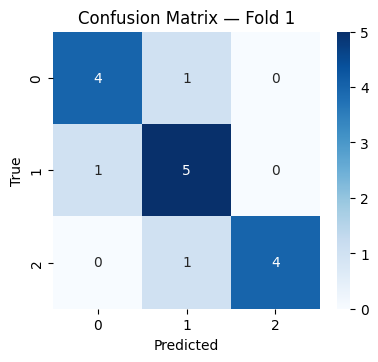

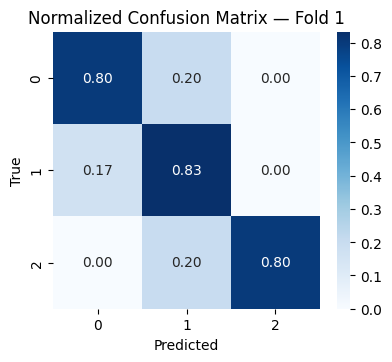


[cv] Fold 2/5 — train=63 val=16
      [epoch 01] train_loss=1.0300 val_acc=0.625
      [epoch 02] train_loss=0.6960 val_acc=0.812
      [epoch 03] train_loss=0.5878 val_acc=0.625
      [epoch 04] train_loss=0.5790 val_acc=0.750
      [epoch 05] train_loss=0.5382 val_acc=0.812
      [early stopping] no improvement for 3 epochs → stop training
[metrics][fold 2] MAE=0.188 QWK=0.824 ACC=0.812 RHO=0.842 ECE=0.285 BAL=0.800 F1=0.813
[compare][fold 2] vs baseline  MAE=1.000 QWK=0.000 ACC=0.167 RHO=nan ECE=0.317 BAL=0.167 F1=0.000


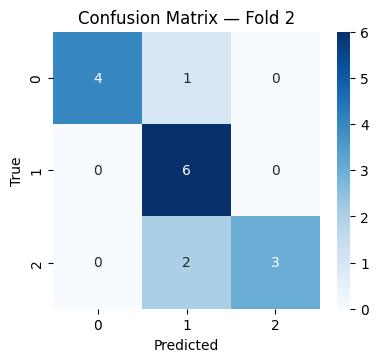

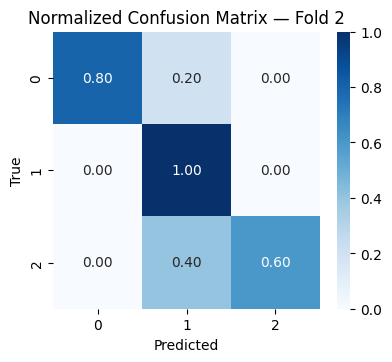


[cv] Fold 3/5 — train=63 val=16
      [epoch 01] train_loss=1.0421 val_acc=0.750
      [epoch 02] train_loss=0.7376 val_acc=0.812
      [epoch 03] train_loss=0.6752 val_acc=0.812
      [epoch 04] train_loss=0.5640 val_acc=0.812
      [epoch 05] train_loss=0.4913 val_acc=0.750
      [early stopping] no improvement for 3 epochs → stop training
[metrics][fold 3] MAE=0.188 QWK=0.842 ACC=0.812 RHO=0.878 ECE=0.262 BAL=0.811 F1=0.809
[compare][fold 3] vs baseline  MAE=1.000 QWK=0.000 ACC=0.167 RHO=nan ECE=0.317 BAL=0.167 F1=0.000


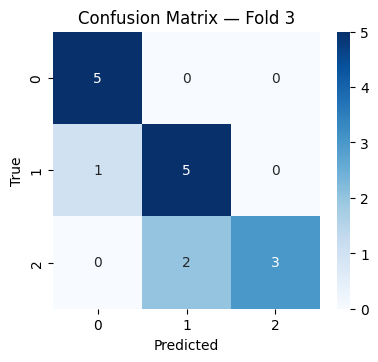

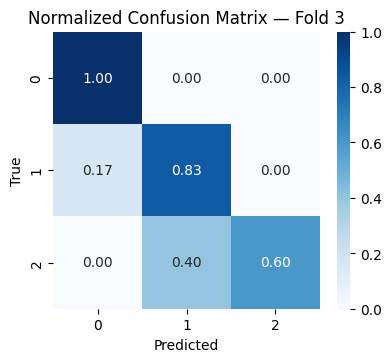


[cv] Fold 4/5 — train=63 val=16
      [epoch 01] train_loss=1.0188 val_acc=0.750
      [epoch 02] train_loss=0.7110 val_acc=0.688
      [epoch 03] train_loss=0.5750 val_acc=0.750
      [epoch 04] train_loss=0.5060 val_acc=0.812
      [epoch 05] train_loss=0.5063 val_acc=0.688
      [epoch 06] train_loss=0.4563 val_acc=0.750
      [epoch 07] train_loss=0.4347 val_acc=0.750
      [early stopping] no improvement for 3 epochs → stop training
[metrics][fold 4] MAE=0.188 QWK=0.842 ACC=0.812 RHO=0.844 ECE=0.280 BAL=0.811 F1=0.819
[compare][fold 4] vs baseline  MAE=1.000 QWK=0.000 ACC=0.167 RHO=nan ECE=0.317 BAL=0.167 F1=0.000


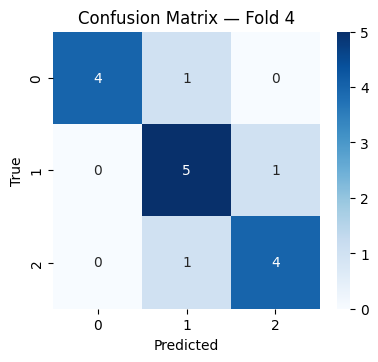

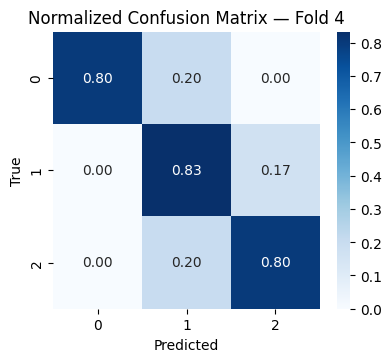


[cv] Fold 5/5 — train=64 val=15
      [epoch 01] train_loss=0.9784 val_acc=0.667
      [epoch 02] train_loss=0.6897 val_acc=0.667
      [epoch 03] train_loss=0.5419 val_acc=0.667
      [epoch 04] train_loss=0.5686 val_acc=0.800
      [epoch 05] train_loss=0.5528 val_acc=0.800
      [epoch 06] train_loss=0.4263 val_acc=0.733
      [epoch 07] train_loss=0.4533 val_acc=0.800
      [early stopping] no improvement for 3 epochs → stop training
[metrics][fold 5] MAE=0.200 QWK=0.857 ACC=0.800 RHO=0.884 ECE=0.195 BAL=0.800 F1=0.796
[compare][fold 5] vs baseline  MAE=1.000 QWK=0.000 ACC=0.167 RHO=nan ECE=0.317 BAL=0.167 F1=0.000


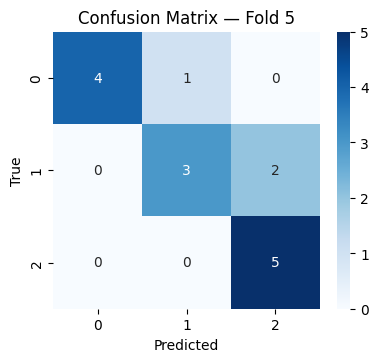

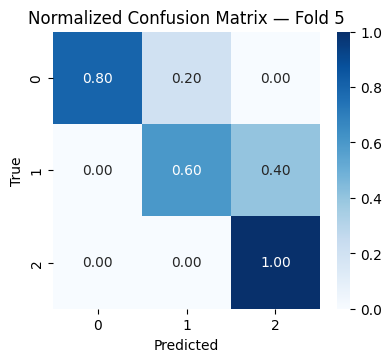


[cv] Summary (mean ± std):
    MAE: 0.190 ± 0.006
    QWK: 0.841 ± 0.012
    ACC: 0.810 ± 0.006
    RHO: 0.859 ± 0.021
    ECE: 0.250 ± 0.038
    BAL: 0.807 ± 0.006
     F1: 0.811 ± 0.010

[done] CV complete. Now training on all data …
[train] class_weights=[1.0479999780654907, 0.9039999842643738, 1.0479999780654907]
[final-train] epoch 01/50 | loss=1.0640 acc=0.5063
[final-train] epoch 02/50 | loss=0.8359 acc=0.7342
[final-train] epoch 03/50 | loss=0.6799 acc=0.7595
[final-train] epoch 04/50 | loss=0.6028 acc=0.7215
[final-train] epoch 05/50 | loss=0.5415 acc=0.7722
[final-train] epoch 06/50 | loss=0.4782 acc=0.7595
[final-train] epoch 07/50 | loss=0.4436 acc=0.7975
[final-train] epoch 08/50 | loss=0.4115 acc=0.8354
[final-train] epoch 09/50 | loss=0.4026 acc=0.8354
[final-train] epoch 10/50 | loss=0.3579 acc=0.8734
[final-train] epoch 11/50 | loss=0.3623 acc=0.8608
[final-train] epoch 12/50 | loss=0.3405 acc=0.8608
[final-train] epoch 13/50 | loss=0.3106 acc=0.8608
[final-train] epo

In [15]:
# ------------------------------------------------------------------------------
# 11) Execute
# ------------------------------------------------------------------------------

if __name__ == "__main__":
    main()

In [16]:
# === ROBUST INFERENCE SMOKE TEST (Attention Pooling) ===
import os, glob, json, torch, numpy as np
import torch.nn as nn

# Use the same CACHE_DIR if it's defined in your notebook
CACHE_DIR = globals().get("CACHE_DIR", "/kaggle/working/cache")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def find_model_path():
    pref = "/kaggle/working/final_mlp.pt"
    if os.path.exists(pref): return pref
    candidates = sorted(glob.glob("/kaggle/working/*.pt") + glob.glob("/kaggle/working/*.pth"),
                        key=os.path.getmtime, reverse=True)
    if not candidates:
        raise FileNotFoundError("No model file found in /kaggle/working. Run the training cell first.")
    return candidates[0]

def find_one_npz_with_clips():
    # Prefer the chosen CACHE_DIR with raw per-clip caches
    picks = []
    if os.path.isdir(CACHE_DIR):
        picks = [p for p in glob.glob(os.path.join(CACHE_DIR, "*.npz"))]
    # Fallback: search anywhere under /kaggle/working for a .npz that contains 'clips'
    if not picks:
        picks = sorted(glob.glob("/kaggle/working/**/*.npz", recursive=True))
    if not picks:
        raise FileNotFoundError("No .npz found. Build the per-clip cache first (should contain key 'clips').")
    # Choose the first one that actually has 'clips'
    for p in sorted(picks):
        try:
            with np.load(p, allow_pickle=True) as data:
                if "clips" in data.files:
                    return p
        except Exception:
            pass
    raise FileNotFoundError("Found .npz files, but none contain 'clips'. Rebuild cache with per-clip embeddings.")

MODEL_PATH = find_model_path()
ckpt = torch.load(MODEL_PATH, map_location="cpu")
in_dim      = int(ckpt["in_dim"])
attn_dim    = int(ckpt["attn_dim"])
hidden_dim  = int(ckpt["hidden_dim"])
num_classes = int(ckpt["num_classes"])
dropout     = float(ckpt.get("dropout", 0.30))

# Recreate the attention+MLP model exactly like training
class ClipAttentionClassifier(nn.Module):
    def __init__(self, in_dim, attn_dim, hidden_dim, num_classes=3, dropout=0.30):
        super().__init__()
        self.attn_W  = nn.Linear(in_dim, attn_dim)
        self.attn_v  = nn.Linear(attn_dim, 1)
        self.classifier = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )
    def forward(self, x, lengths):
        # x: [B,N,D], lengths: [B]
        B, N, D = x.shape
        e = self.attn_v(torch.tanh(self.attn_W(x))).squeeze(-1)  # [B,N]
        mask = (torch.arange(N, device=x.device).unsqueeze(0) < lengths.unsqueeze(1))
        e_masked = e.masked_fill(~mask, -1e9)
        weights = torch.softmax(e_masked, dim=1)                 # [B,N]
        pooled  = torch.sum(weights.unsqueeze(-1) * x, dim=1)    # [B,D]
        logits  = self.classifier(pooled)
        return logits

# Build and load weights
model = ClipAttentionClassifier(in_dim, attn_dim, hidden_dim, num_classes, dropout).to(DEVICE)
model.load_state_dict(ckpt["state_dict"], strict=True)
model.eval()

# Optional class map
CLASSMAP_JS = "/kaggle/working/class_map.json"
if os.path.exists(CLASSMAP_JS):
    try:
        with open(CLASSMAP_JS, "r") as f:
            tmp = json.load(f)
        class_map = {int(k): v for k, v in tmp.items()}
    except Exception:
        class_map = {i: f"class_{i}" for i in range(num_classes)}
else:
    class_map = {i: f"class_{i}" for i in range(num_classes)}

# Pick a sample per-clip cache
sample_npz = find_one_npz_with_clips()
with np.load(sample_npz, allow_pickle=True) as data:
    clips = data["clips"].astype("float32")  # [N, in_dim]

# Prepare batch tensors
N = clips.shape[0]
x = torch.from_numpy(clips).unsqueeze(0).to(DEVICE)   # [1, N, in_dim]
lengths = torch.tensor([N], dtype=torch.long, device=DEVICE)

with torch.no_grad():
    logits = model(x, lengths).squeeze(0).cpu()       # [num_classes]
    prob = torch.softmax(logits, dim=0).numpy()
    pred = int(prob.argmax())

print(f"[inference] model={os.path.basename(MODEL_PATH)} | sample={os.path.basename(sample_npz)} | clips={N}")
print(f"           pred={pred} ({class_map.get(pred, pred)}) | probs={np.round(prob,3)}")


[inference] model=final_mlp.pt | sample=anjaly_1.npz | clips=5
           pred=2 (class_2) | probs=[0.001 0.135 0.865]
